In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
# %load_ext autoreload
# %autoreload 2
import os
from archetypes import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [3]:
# RGB values for each region
region_color = {
    "Ocean": (0.2154516905067, 0.295, 0.5078367867510504),
    "Desert": (0.78, 0.51, 0.1892045842),
    "Biogenic": (0.12071162840208301, 0.4357915995132193, 0.2463679091477368),
    "Urban": (0.7, 0.7, 0.65),
    "Almost Polar": (0.5184891135337089, 0.7194769933793438, 0.7518803726887796),
    "Polar": (0.5632111255041908, 0.758620966612444, 0.7764634182455044)
}

# Region for each location
location_to_region = {
    'Amazon': 'Biogenic',
    'AtlanticOcean': 'Ocean',
    'Beijing': 'Urban',
    'Borneo': 'Biogenic',
    'CapeGrim': 'Polar',
    'Congo': 'Biogenic',
    'ElDjouf': 'Desert',
    'Graciosa': 'Ocean',
    'IndianOcean': 'Ocean',
    'Kinshasa': 'Urban',
    'LosAngeles': 'Urban',
    'McMurdo': 'Polar',
    'Ozarks': 'Biogenic',
    'PacificOcean': 'Ocean',
    'Paris': 'Urban',
    'Utqiagvik': 'Almost Polar'
}

In [4]:
#For categorical
# categorical = True, legend_color = dictionary with keys as labels and values as colors
# For continuous
# categorical = False, legend_color = array of values according to which to color and cmap as name of color map to use

def plot_simplex(n_archetypes, alfa, color_vertex, plot_args={}, grid_on=True, cmap='viridis', categorical=True, legend_color=None, label = True):
    vertex_colors = ['red', 'blue', 'green', 'yellow']
    labels = ('A'+str(i + 1) for i in range(n_archetypes))
    rotate_labels = True
    label_offset = 0.10
    data = alfa.T
    scaling = False
    sides = n_archetypes
    basis = np.array(
        [
            [
                np.cos(2*_*pi/sides + 90*pi/180),
                np.sin(2*_*pi/sides + 90*pi/180)
            ] 
            for _ in range(sides)
        ]
    )     

    print(basis)
    # If data is Nxsides, newdata is Nx2.
    if scaling:
        # Scales data for you.
        newdata = np.dot((data.T / data.sum(-1)).T, basis)
    else:
        # Assumes data already sums to 1.
        newdata = np.dot(data, basis)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    for i, l in enumerate(labels):
        if i >= sides:
            break
        x = basis[i, 0]
        y = basis[i, 1]
        if rotate_labels:
            angle = 180*np.arctan(y/x)/pi + 90
            if angle > 90 and angle <= 270:
                angle = (angle + 180) % 360
        else:
            angle = 0
        ax.text(
            x*(1 + label_offset),
            y*(1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle
        )

    # Clear normal matplotlib axes graphics.
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)

    # Plot border
    lst_ax_0 = []
    lst_ax_1 = []
    for _ in range(sides):
        lst_ax_0.append(basis[_, 0])
        lst_ax_1.append(basis[_, 1])

    lst_ax_0.append(basis[0, 0])
    lst_ax_1.append(basis[0, 1])

    ax.plot(lst_ax_0, lst_ax_1, linewidth=1, zorder=2) 
    
    # Plot vertices
    if color_vertex:
        for i in range(len(color_vertex)):
            v = color_vertex[i]
            ax.scatter(basis[v, 0], basis[v, 1], color=vertex_colors[i], s=200, zorder=4)

    if len(plot_args) == 0:
        ax.scatter(newdata[:, 0], newdata[:, 1], color='black', zorder=3, alpha=0.5)
    else:
        if ('marker' in plot_args):   
            marker_vals = plot_args['marker'].values
            marker_unq = np.unique(marker_vals)                
            
            for marker in marker_unq:
                row_idx = np.where(marker_vals == marker)
                tmp_arg = {}
                for keys in plot_args:
                    if (keys!= 'marker'):
                        tmp_arg[keys] = plot_args[keys].values[row_idx]
                
                ax.scatter(newdata[row_idx,0],newdata[row_idx,1], **tmp_arg, marker =  marker, alpha=0.5, zorder=3)
        else:
            if categorical:
                ax.scatter(newdata[:, 0], newdata[:, 1], **plot_args, marker='s', zorder=3, alpha=0.5)
            else:
                values = legend_color
                # Normalize the values
                norm = Normalize(vmin=min(values), vmax=max(values))
                # Choose a colormap
                cmap = cm.get_cmap(cmap)
                # Map each normalized value to a color
                colors = [cmap(norm(value)) for value in values]
                plot_args['color'] = colors
                
                ax.scatter(newdata[:, 0], newdata[:, 1], **plot_args, marker='s', zorder=3, alpha=0.5)
                
        
    if label:    
        # Add color bar if numerical data
        if not categorical:

            values = legend_color
            # Normalize the values
            norm = Normalize(vmin=min(values), vmax=max(values))

            # Create a ScalarMappable object using a colormap and the normalized values
            scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

            # Create an inset axis for the colorbar
            cb_ax = ax.inset_axes([1.15, 0.5, 0.05, 0.4])  # Adjust the position and size as needed

            # Add the colorbar to the inset axis
            colorbar = plt.colorbar(scalar_map, cax=cb_ax, orientation='vertical', label=label)

            # Adjust colorbar properties
            colorbar.minorticks_on()  # Show minor ticks
            colorbar.alpha = 0.5  # Set transparency


        else:
            legend_labels =  legend_color.keys() # Update with actual labels
            legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_color.values()]
            ax.legend(legend_handles, legend_labels, loc='lower right', bbox_to_anchor=(1.15, 0.5))

            
    plt.show()

In [5]:
df = pd.read_csv('GEOS_CF_dataset.csv', index_col='filename')
df.head()

location         timestamp  longitude  \
filename                                                                     
AmazonTwilight_L10_20180101_2145.txt   Amazon  2018/01/01 21:45   -62.3631   
AmazonTwilight_L10_20180101_2200.txt   Amazon  2018/01/01 22:00   -62.3631   
AmazonTwilight_L10_20180101_2215.txt   Amazon  2018/01/01 22:15   -62.3631   
AmazonTwilight_L10_20180101_2230.txt   Amazon  2018/01/01 22:30   -62.3631   
AmazonTwilight_L10_20180102_0930.txt   Amazon  2018/01/02 09:30   -62.3631   

                                      latitude  level  temperature  pressure  \
filename                                                                       
AmazonTwilight_L10_20180101_2145.txt    -3.071     10       291.83  858.5508   
AmazonTwilight_L10_20180101_2200.txt    -3.071     10       291.79  858.6730   
AmazonTwilight_L10_20180101_2215.txt    -3.071     10       291.79  858.5559   
AmazonTwilight_L10_20180101_2230.txt    -3.071     10       291.78  858.6656   
AmazonTwilight_L10_20180102_0930.txt    -3.071     10       290.06  860.1269   

                                      air_number_density  average_water  \
filename                                                                  
AmazonTwilight_L10_20180101_2145.txt        2.097000e+19        0.02261   
AmazonTwilight_L10_20180101_2200.txt        2.098000e+19        0.02258   
AmazonTwilight_L10_20180101_2215.txt        2.098000e+19        0.02260   
AmazonTwilight_L10_20180101_2230.txt        2.098000e+19        0.02259   
AmazonTwilight_L10_20180102_0930.txt        2.114000e+19        0.02196   

                                      cloud_fraction  ...          K906  \
filename                                              ...                 
AmazonTwilight_L10_20180101_2145.txt        0.000094  ...  9.194149e-08   
AmazonTwilight_L10_20180101_2200.txt        0.000083  ...  3.169007e-08   
AmazonTwilight_L10_20180101_2215.txt        0.000000  ...  4.837509e-09   
AmazonTwilight_L10_20180101_2230.txt        0.000047  ...  1.609501e-10   
AmazonTwilight_L10_20180102_0930.txt        0.256800  ...  5.514297e-11   

                                              K907          K908  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  4.366680e-06  1.759491e-06   
AmazonTwilight_L10_20180101_2200.txt  1.511636e-06  5.944569e-07   
AmazonTwilight_L10_20180101_2215.txt  2.250509e-07  9.211448e-08   
AmazonTwilight_L10_20180101_2230.txt  7.477167e-09  3.080839e-09   
AmazonTwilight_L10_20180102_0930.txt  2.634032e-09  1.047952e-09   

                                              K909          K910  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  3.077669e-07  1.326652e-06   
AmazonTwilight_L10_20180101_2200.txt  1.093729e-07  4.614411e-07   
AmazonTwilight_L10_20180101_2215.txt  1.783656e-08  6.799260e-08   
AmazonTwilight_L10_20180101_2230.txt  5.565965e-10  2.258006e-09   
AmazonTwilight_L10_20180102_0930.txt  2.160709e-10  8.004517e-10   

                                              K911          K912  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  3.077669e-07  3.077669e-07   
AmazonTwilight_L10_20180101_2200.txt  1.093729e-07  1.093729e-07   
AmazonTwilight_L10_20180101_2215.txt  1.783656e-08  1.783656e-08   
AmazonTwilight_L10_20180101_2230.txt  5.565965e-10  5.565965e-10   
AmazonTwilight_L10_20180102_0930.txt  2.160709e-10  2.160709e-10   

                                              K913  twilight    region  
filename                                                                
AmazonTwilight_L10_20180101_2145.txt  1.265506e-06      True  Biogenic  
AmazonTwilight_L10_20180101_2200.txt  4.268394e-07      True  Biogenic  
AmazonTwilight_L10_20180101_2215.txt  6.623628e-08      True  Biogenic  
AmazonTwilight_L10_20180101_2230.txt  2.220224e-09      True  Biogenic  
AmazonTw

In [6]:
L1_rates = df[df['level'] == 1].copy()
L1_LA_rates = L1_rates[L1_rates['location'] == 'LosAngeles'].copy()
L1_LA_rates['timestamp'] = pd.to_datetime(L1_LA_rates['timestamp'], format='%Y/%m/%d %H:%M')
L1_LA_rates['month'] = L1_LA_rates['timestamp'].dt.month
April_L1_LA_rates_df = L1_LA_rates[L1_LA_rates['month'] == 4].copy()
April_L1_LA_rates_df

location           timestamp  \
filename                                                                  
LosAngelesTwilight_L1_20180402_0130.txt  LosAngeles 2018-04-02 01:30:00   
LosAngelesTwilight_L1_20180402_0145.txt  LosAngeles 2018-04-02 01:45:00   
LosAngelesTwilight_L1_20180402_0200.txt  LosAngeles 2018-04-02 02:00:00   
LosAngelesTwilight_L1_20180402_0215.txt  LosAngeles 2018-04-02 02:15:00   
LosAngelesTwilight_L1_20180402_0230.txt  LosAngeles 2018-04-02 02:30:00   
...                                             ...                 ...   
LosAngeles_L1_20180402_1945.txt          LosAngeles 2018-04-02 19:45:00   
LosAngeles_L1_20180402_2000.txt          LosAngeles 2018-04-02 20:00:00   
LosAngeles_L1_20180402_2015.txt          LosAngeles 2018-04-02 20:15:00   
LosAngeles_L1_20180402_2030.txt          LosAngeles 2018-04-02 20:30:00   
LosAngeles_L1_20180402_2045.txt          LosAngeles 2018-04-02 20:45:00   

                                         longitude  latitude  level  \
filename                                                              
LosAngelesTwilight_L1_20180402_0130.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0145.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0200.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0215.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0230.txt  -117.9876   34.4658      1   
...                                            ...       ...    ...   
LosAngeles_L1_20180402_1945.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2000.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2015.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2030.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2045.txt          -117.9876   34.4658      1   

                                         temperature  pressure  \
filename                                                         
LosAngelesTwilight_L1_20180402_0130.txt       296.69  911.2661   
LosAngelesTwilight_L1_20180402_0145.txt       296.20  911.3063   
LosAngelesTwilight_L1_20180402_0200.txt       295.56  911.3462   
LosAngelesTwilight_L1_20180402_0215.txt       294.94  911.3923   
LosAngelesTwilight_L1_20180402_0230.txt       294.31  911.4551   
...                                              ...       ...   
LosAngeles_L1_20180402_1945.txt               294.76  910.6889   
LosAngeles_L1_20180402_2000.txt               295.12  910.5688   
LosAngeles_L1_20180402_2015.txt               295.45  910.4555   
LosAngeles_L1_20180402_2030.txt               295.75  910.3490   
LosAngeles_L1_20180402_2045.txt               296.03  910.2340   

                                         air_number_density  average_water  \
filename                                                                     
LosAngelesTwilight_L1_20180402_0130.txt        2.217000e+19       0.006205   
LosAngelesTwilight_L1_20180402_0145.txt        2.221000e+19       0.006339   
LosAngelesTwilight_L1_20180402_0200.txt        2.226000e+19       0.006500   
LosAngelesTwilight_L1_20180402_0215.txt        2.230000e+19       0.006657   
LosAngelesTwilight_L1_20180402_0230.txt        2.235000e+19       0.006815   
...                                                     ...            ...   
LosAngeles_L1_20180402_1945.txt                2.231000e+19       0.006184   
LosAngeles_L1_20180402_2000.txt                2.228000e+19       0.006169   
LosAngeles_L1_20180402_2015.txt                2.225000e+19       0.006184   
LosAngeles_L1_20180402_2030.txt                2.223000e+19       0.006176   
LosAngeles_L1_20180402_2045.txt                2.220000e+19       0.006201   

                                         cloud_fraction  ...          K907  \
filename                                                 ...                 
LosAngelesTwilight_L1_20180402_0130.txt             0.0  ...  3.258781e-06   
LosAngelesTwilight_L1_20180402_0145

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\2047159175.py:23: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



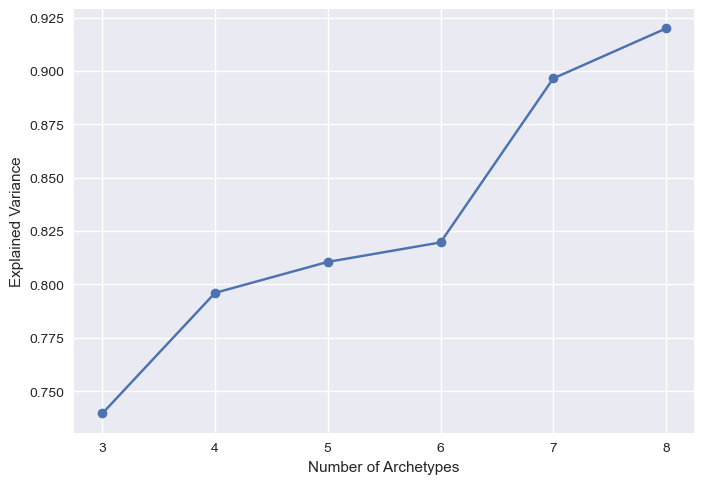

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


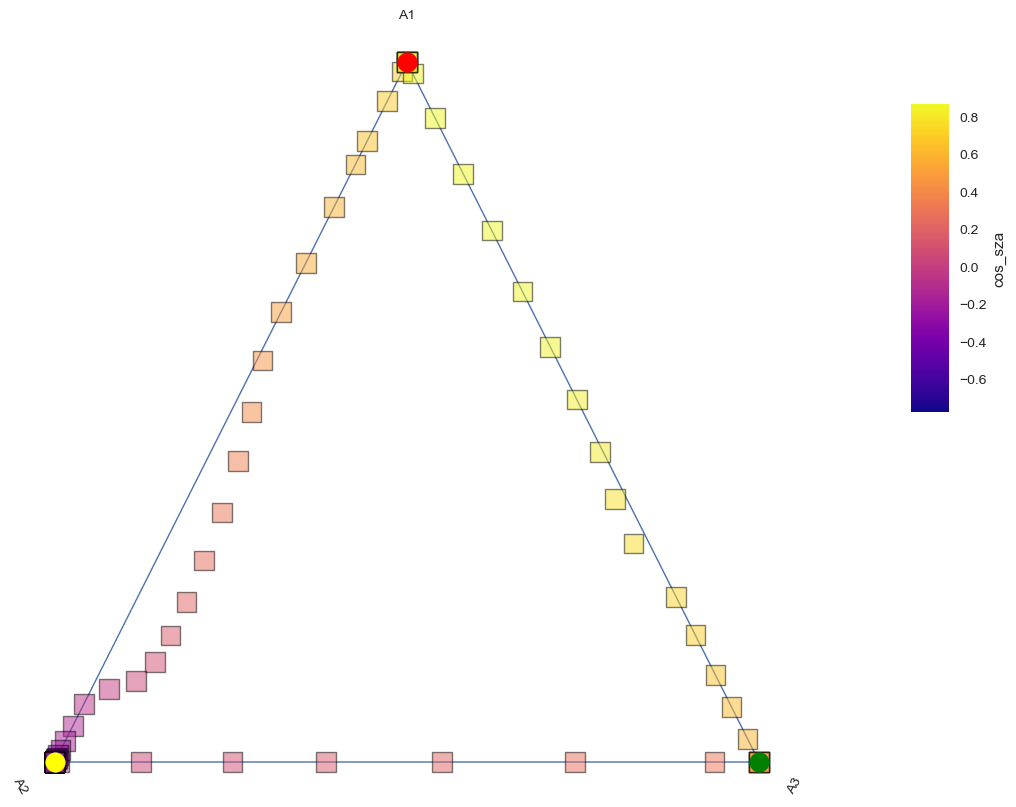

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



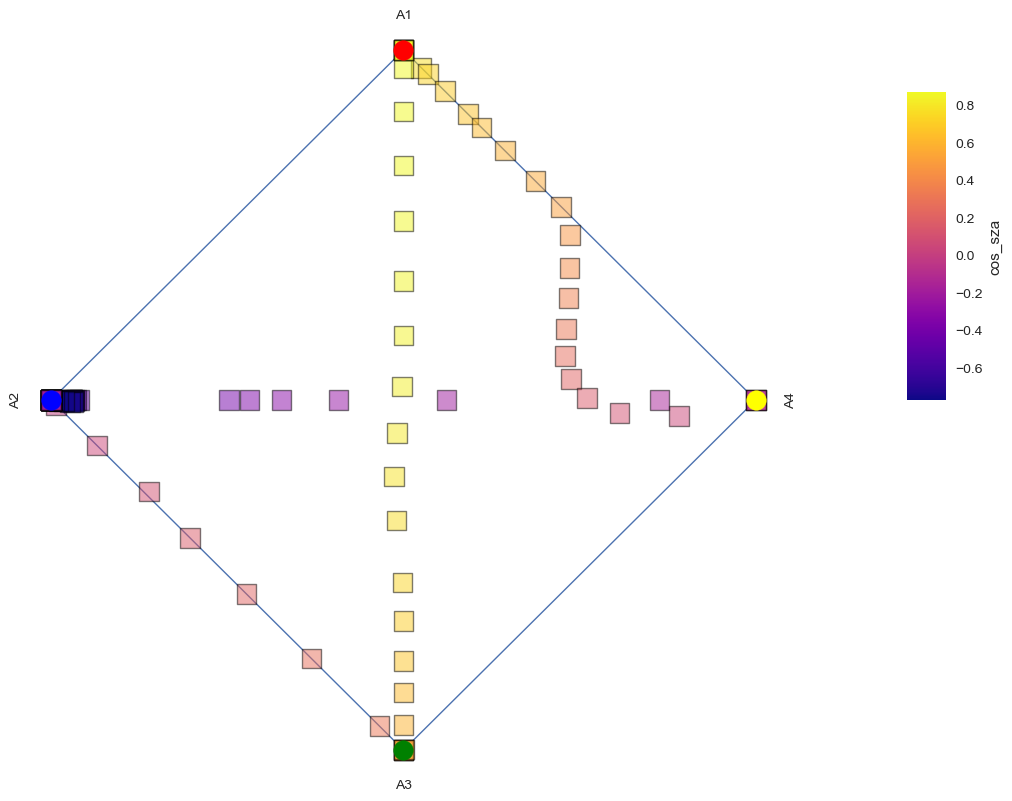

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



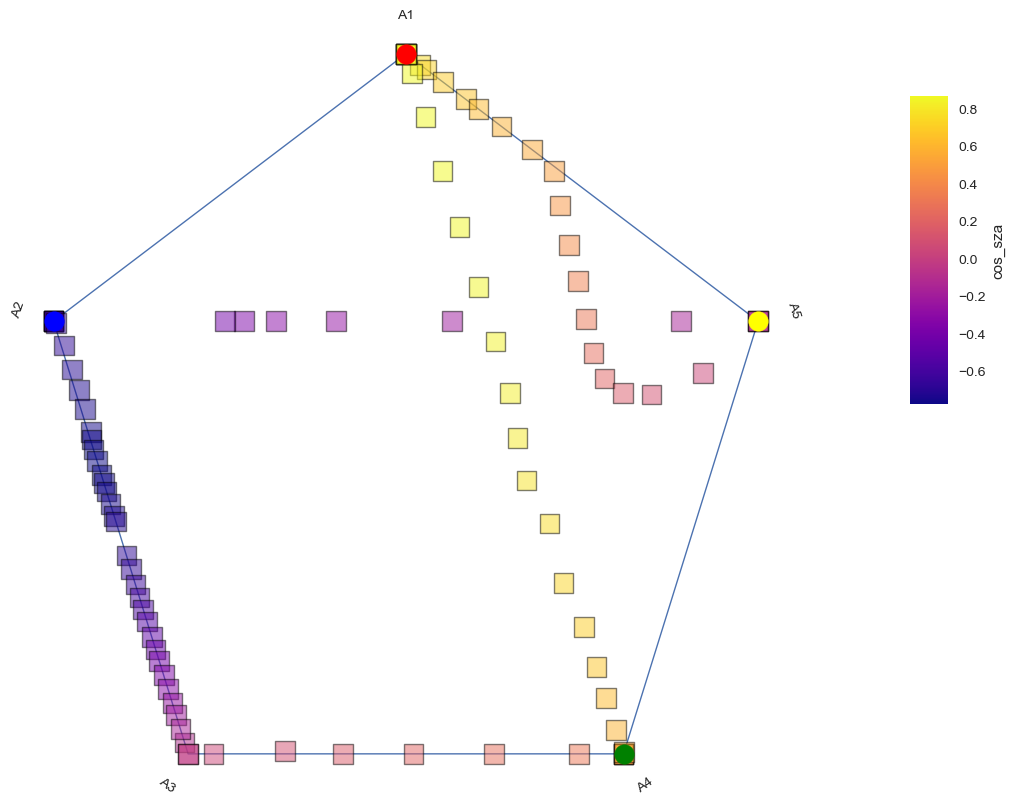

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



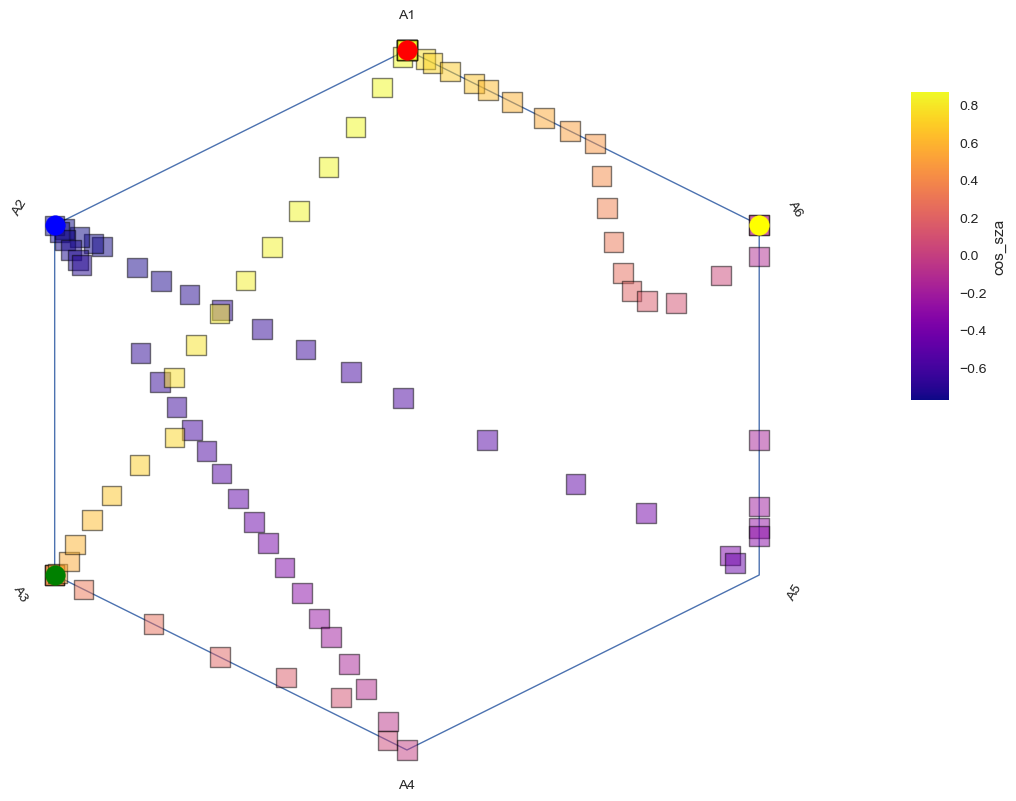

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



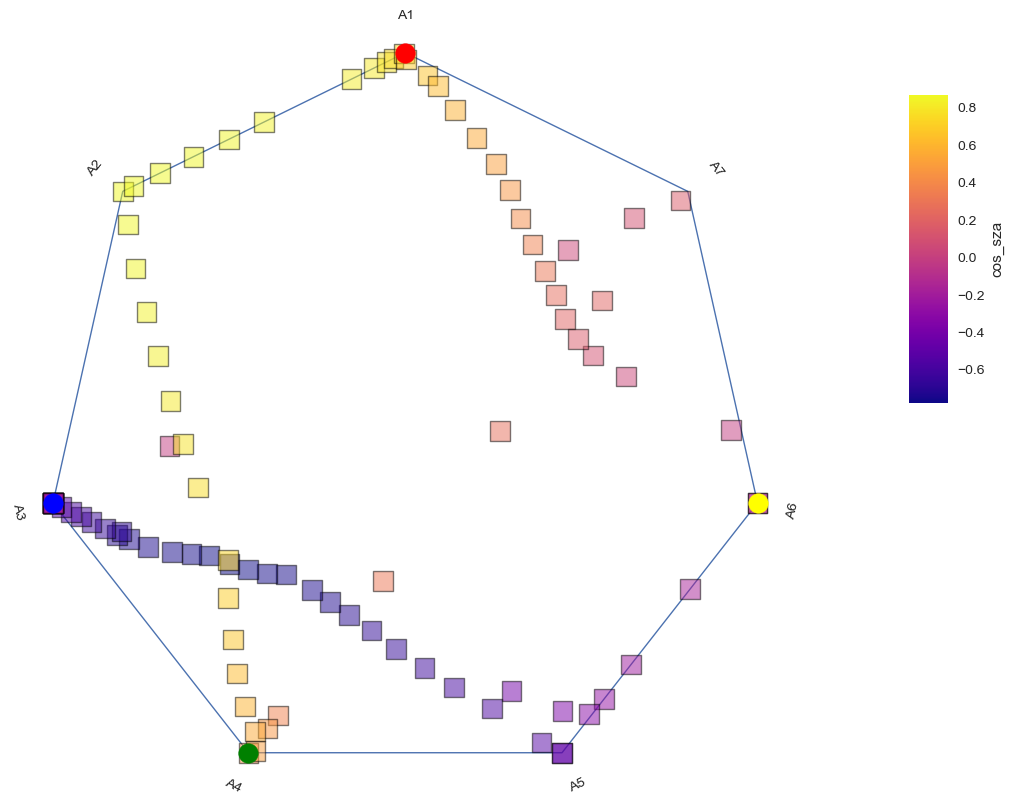

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



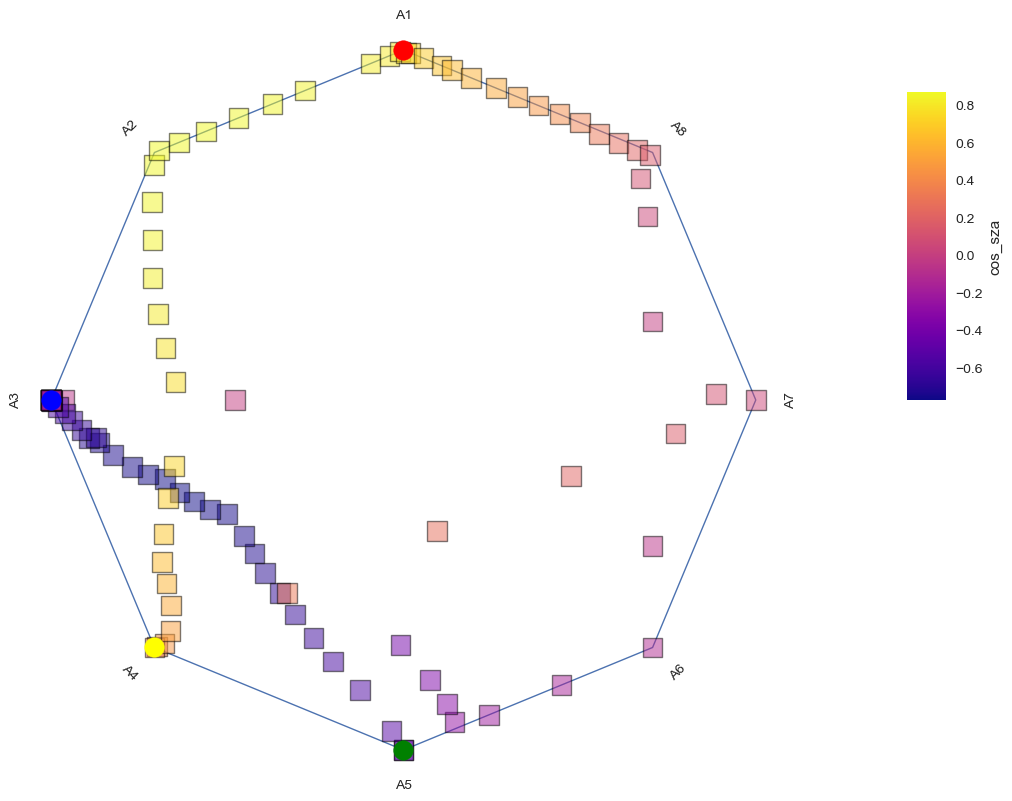

In [40]:
lst_feat = ['R' + str(i) for i in range(1,913+1)]

sc = StandardScaler()
X = April_L1_LA_rates_df[lst_feat].values #Using level1_df here
X_scaled = sc.fit_transform(X)

AA_list_la_l1_april=[]
lst_exp_var_la_l1_april = []
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA_list_la_l1_april.append(AA)
    lst_exp_var_la_l1_april.append(AA.explained_variance_)
    
#explained variance
n_archs = list(range(3, 9))
plt.style.use('seaborn')
plt.plot(n_archs, lst_exp_var_la_l1_april, '-o')
plt.xlabel('Number of Archetypes')
plt.ylabel('Explained Variance')
plt.show()


#coloring - cosine zenith
legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border


#simplex plots    
flag = True
arr1 = AA_list_la_l1_april[1].archetypes.T
color_indices = []
for AA in AA_list_la_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    if flag:
        flag = False
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'cos_sza')
    else:
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'cos_sza')

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



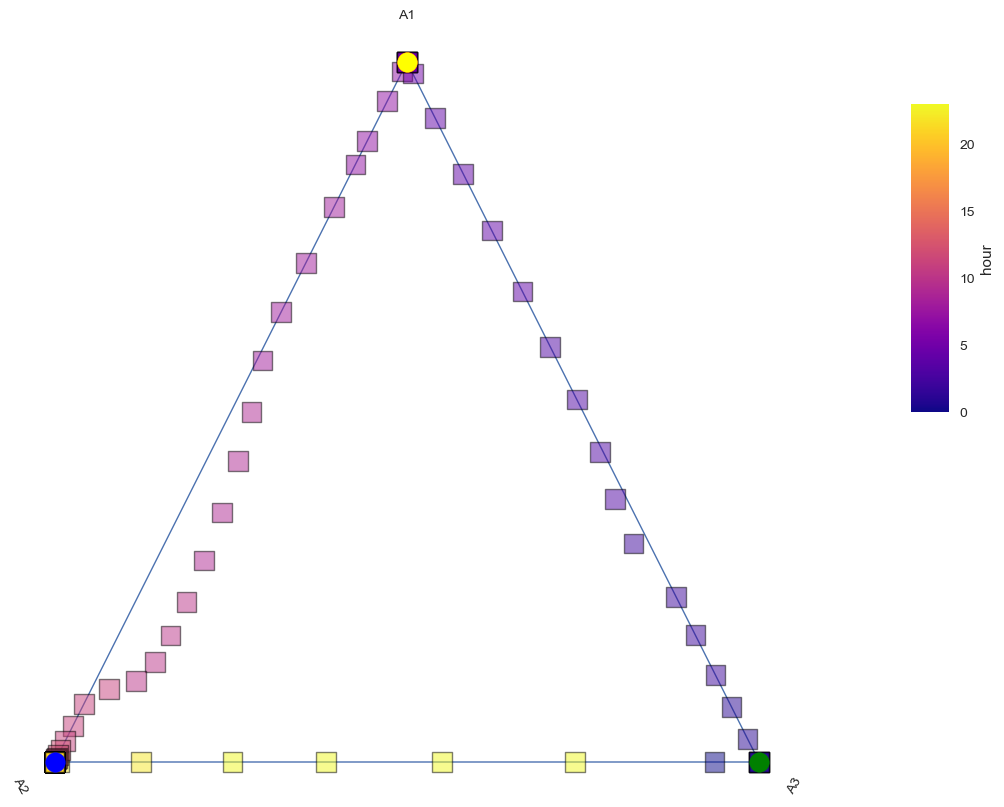

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



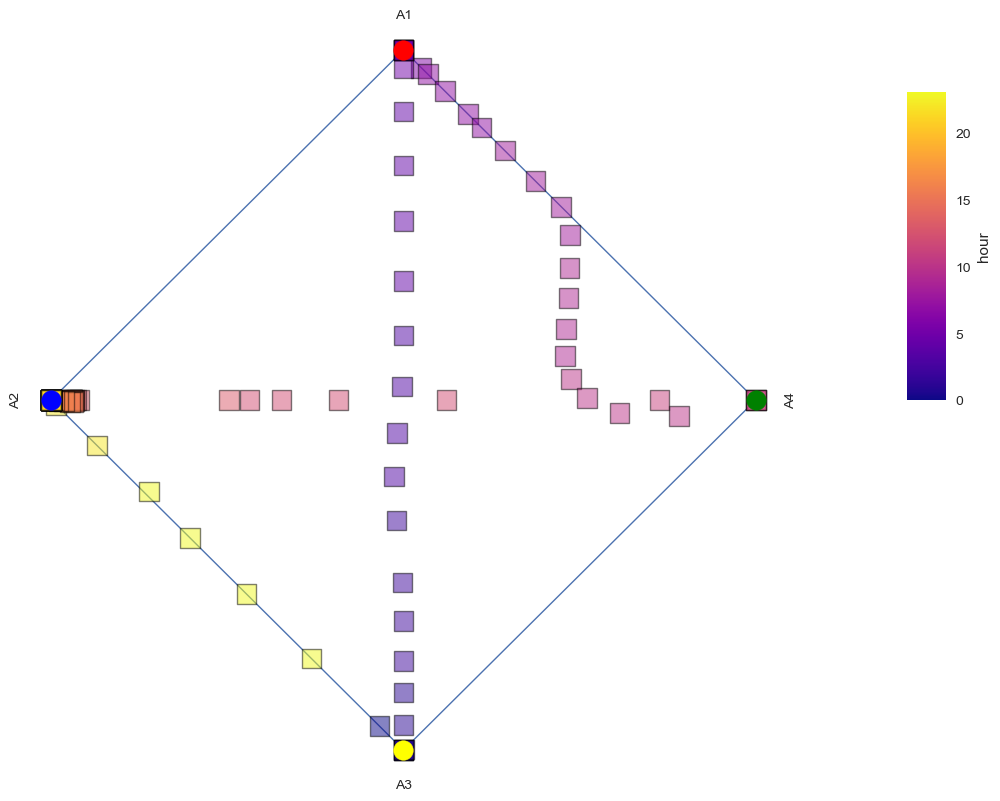

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



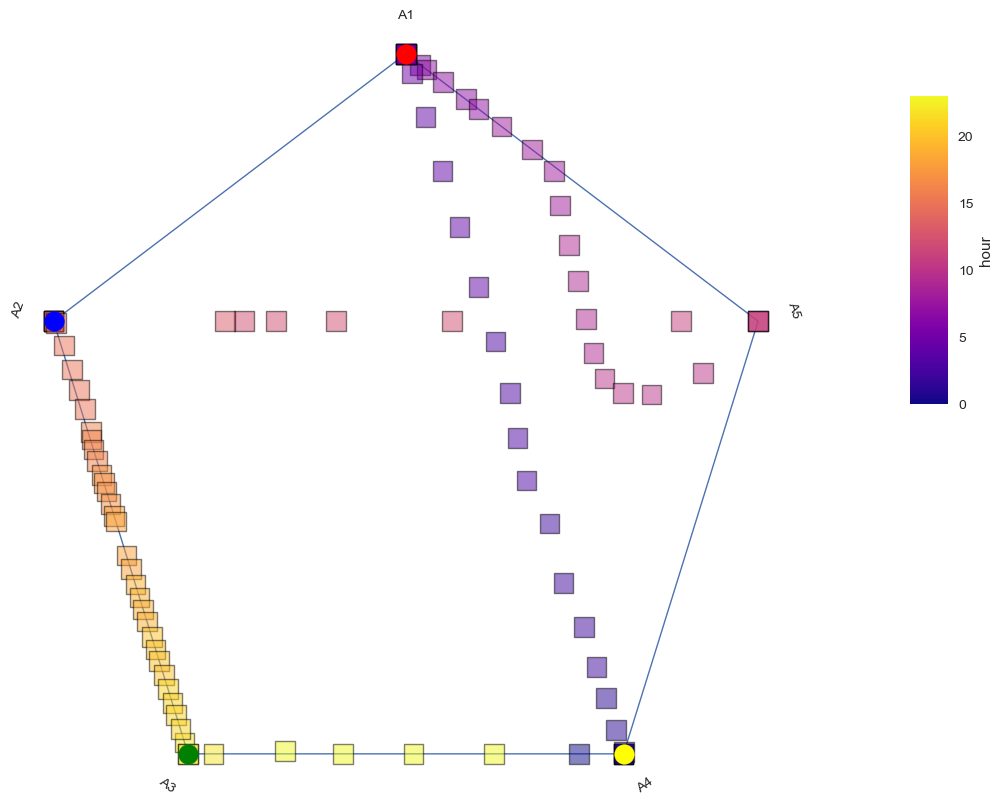

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



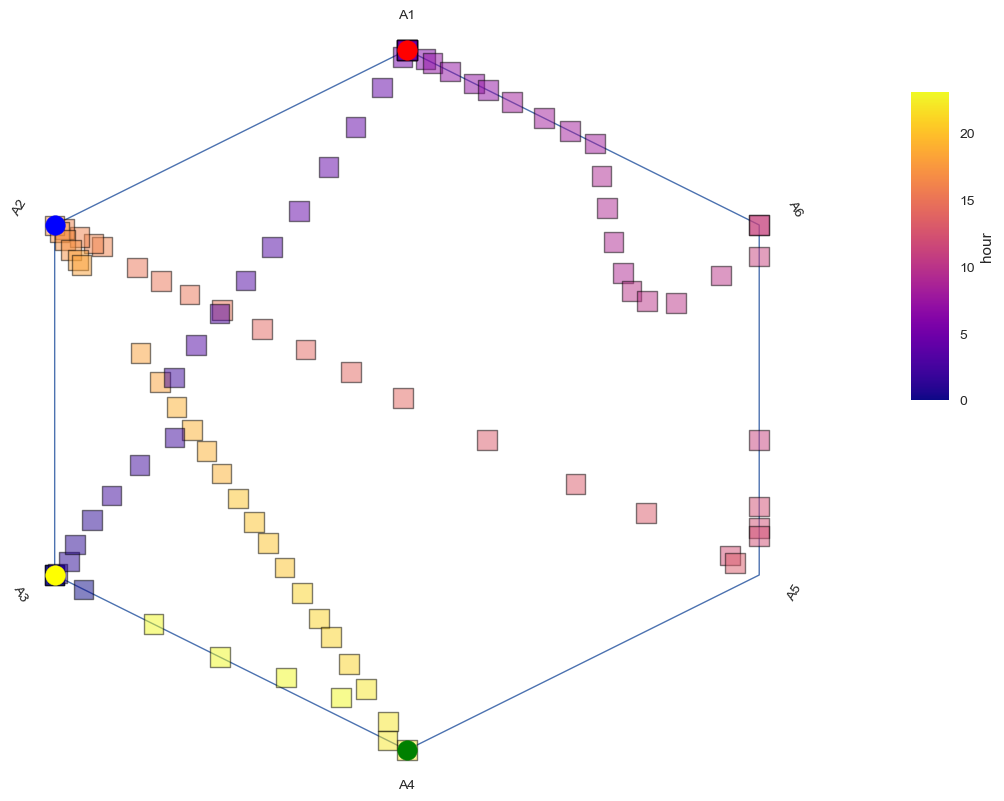

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



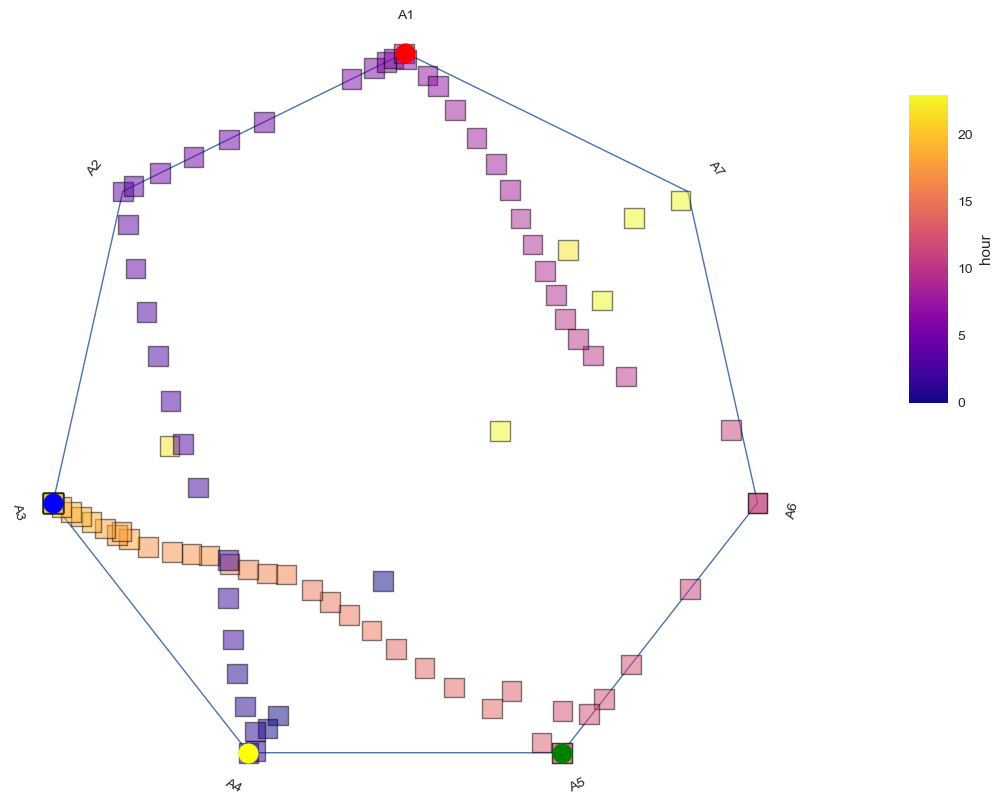

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



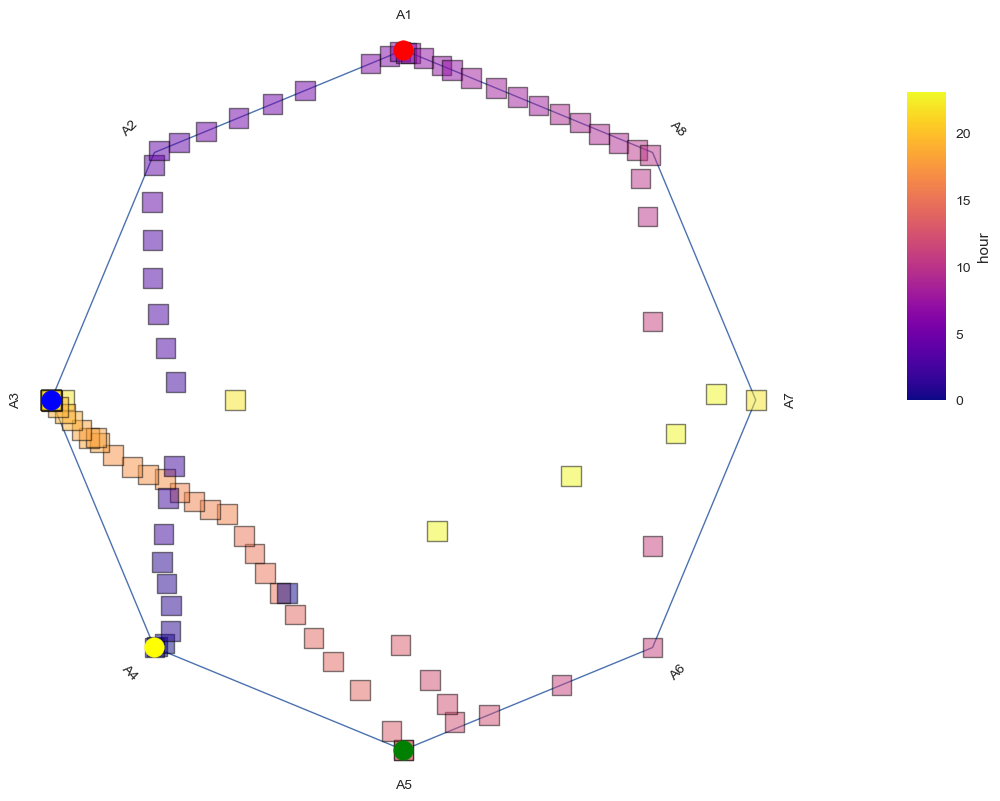

In [50]:
#coloring - cosine zenith
# legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
legend_color = list(April_L1_LA_rates_df['timestamp'].dt.hour)
legend_color = [(i+9)%24 for i in legend_color]
# plot_args = {'color':None}
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border

#simplex plots    
flag = True
arr1 = AA_list_la_l1_april[0].archetypes.T
color_indices = []
for AA in AA_list_la_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'hour')

In [42]:
AA3 = AA_list_la_l1_april[0]

In [43]:
# Create 3D plot
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=AA3.alfa[0], y=AA3.alfa[1], z=AA3.alfa[2], mode='markers', marker=dict(size=5))])

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [44]:
# Create a colormap
cmap = plt.get_cmap('plasma')

# Obtain colors using the colormap
colors = [cmap(val) for val in April_L1_LA_rates_df['cos_sza']]

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=AA3.alfa[0], y=AA3.alfa[1], z=AA3.alfa[2], mode='markers', marker=dict(size=5, color=colors))])

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



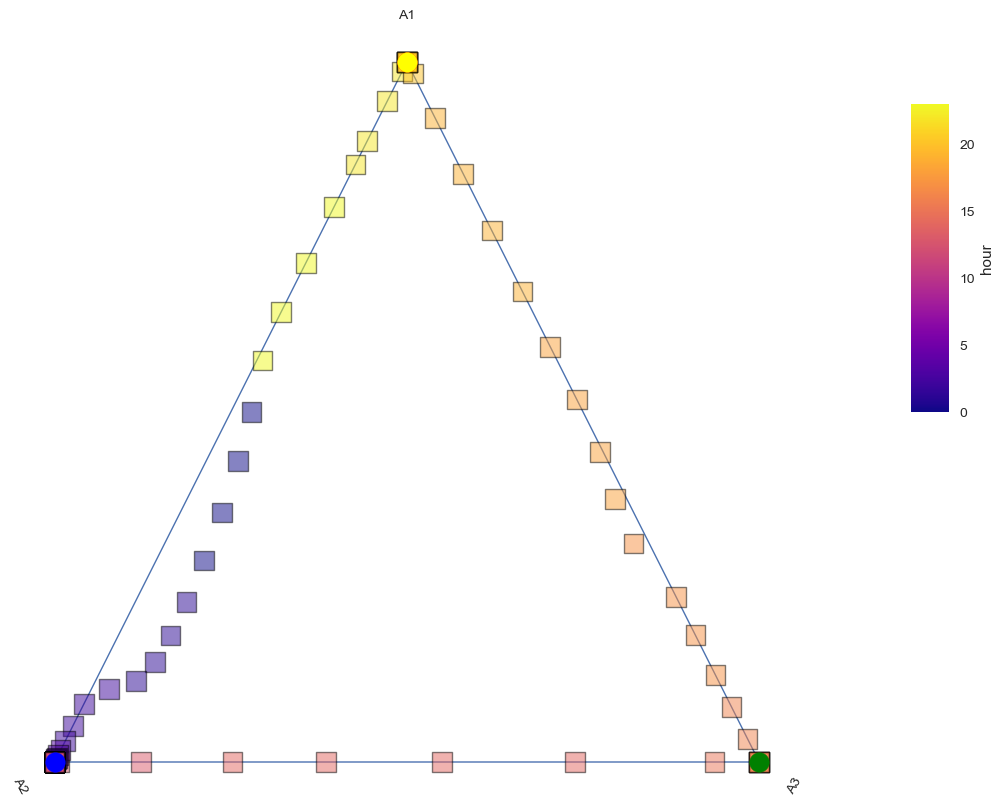

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


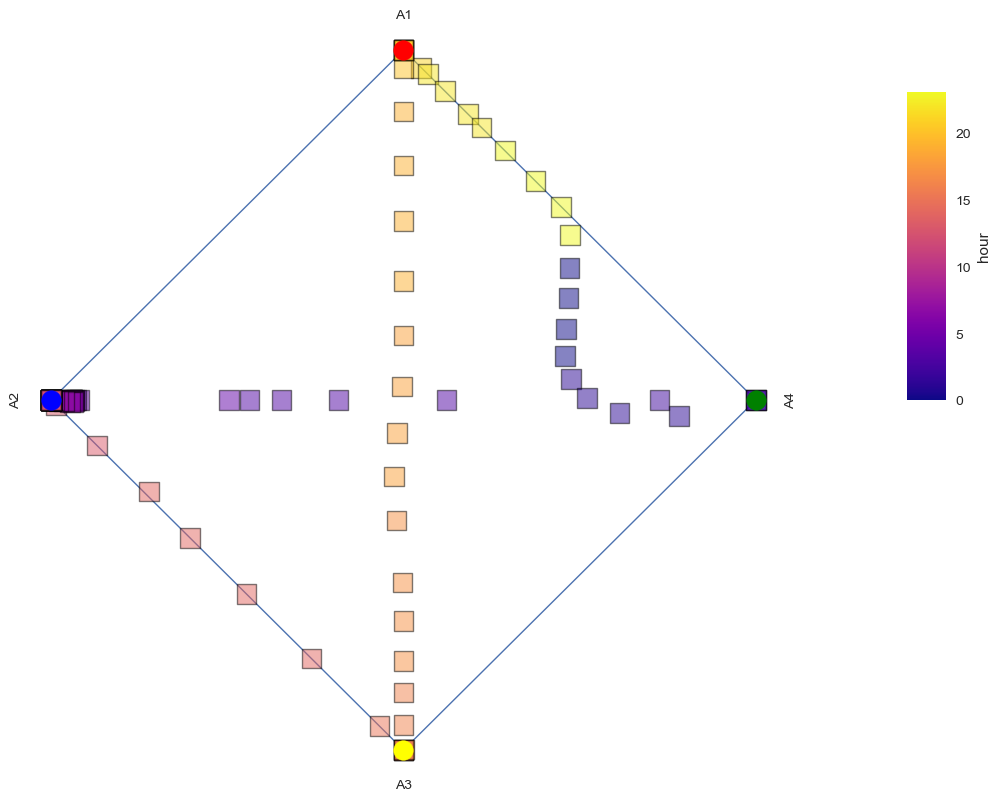

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



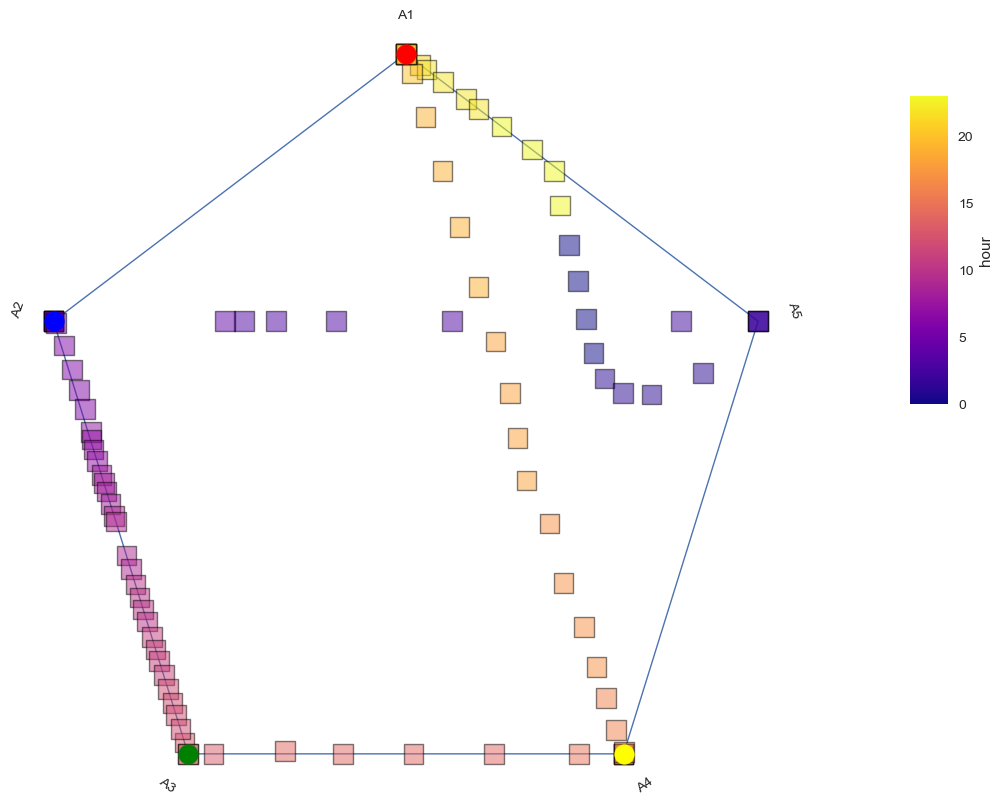

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


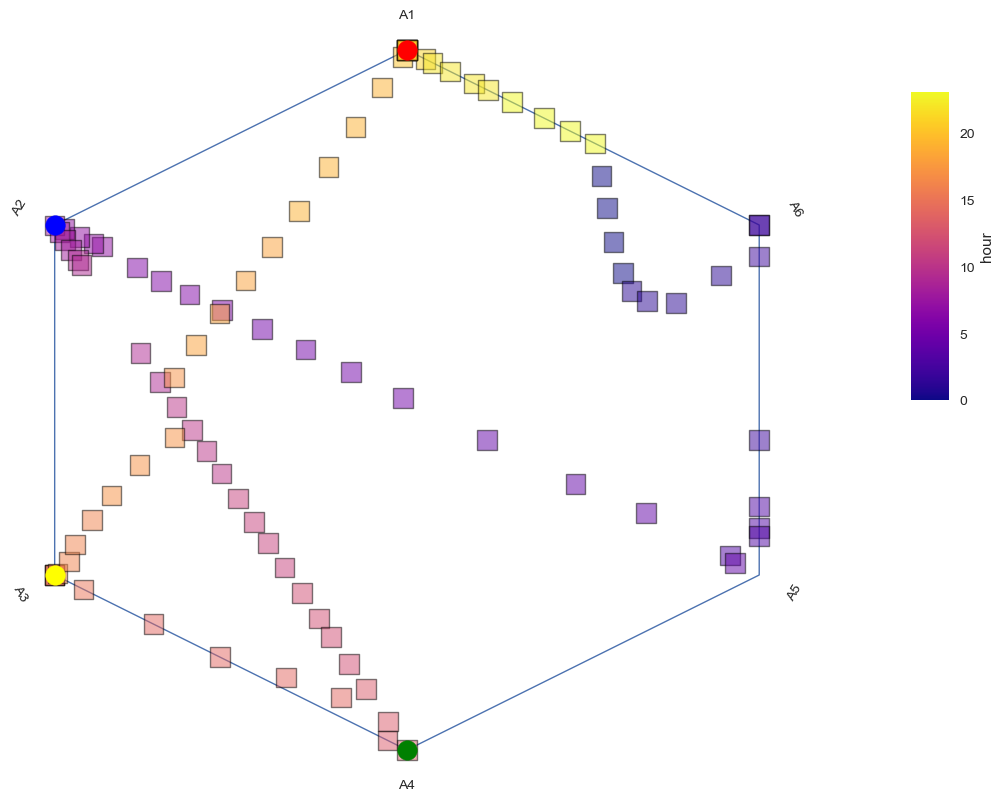

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



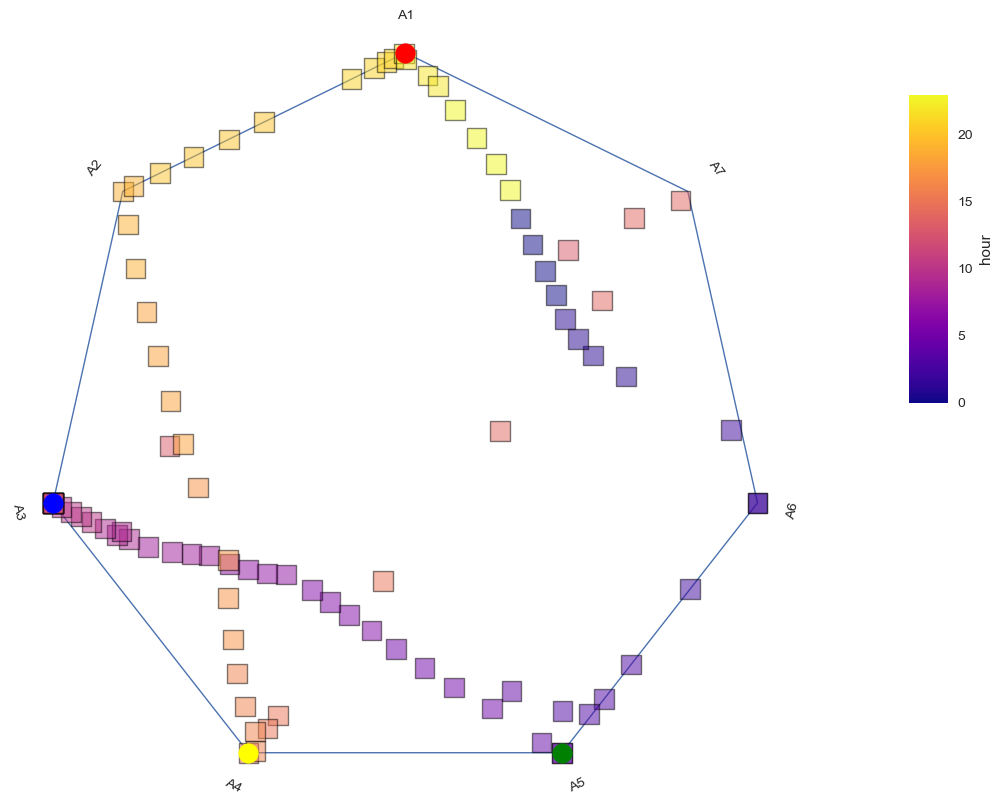

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



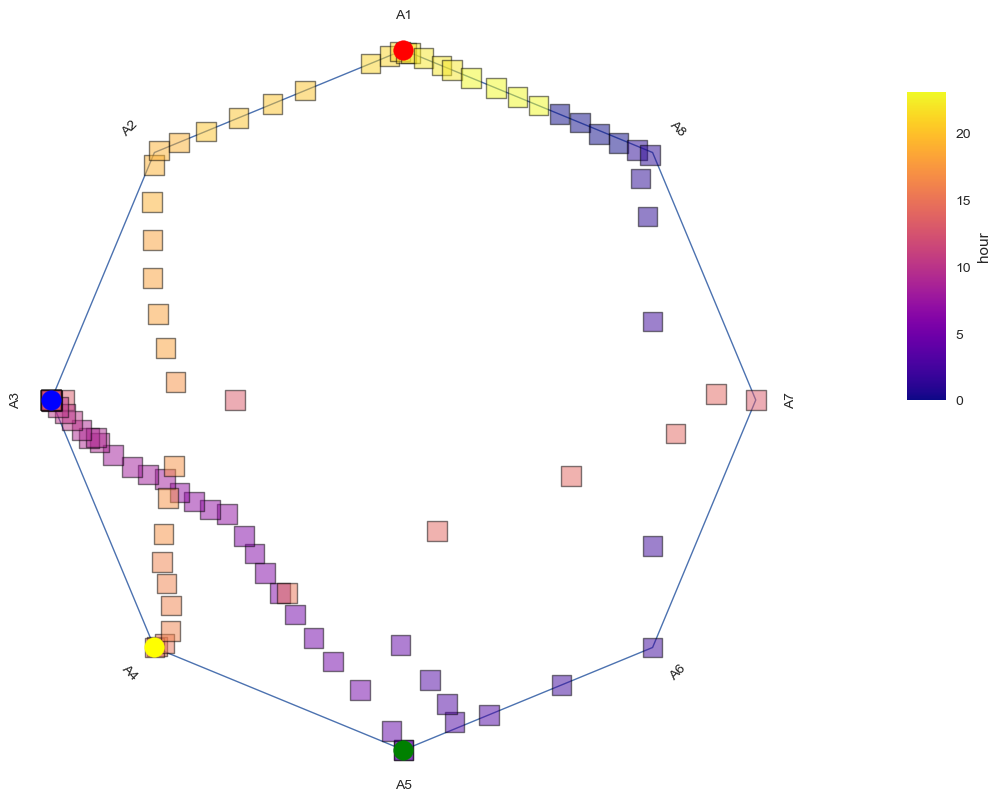

In [45]:
# #coloring - cosine zenith
# # legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
# legend_color = list(April_L1_LA_rates_df['timestamp'].dt.hour)
# plot_args = {'color':None, 's' : 200}
# plot_args['edgecolor'] = 'black'  # Set the color of the marker border
# plot_args['linewidth'] = 1  # Set the width of the marker border

# #simplex plots    
# flag = True
# arr1 = AA_list_la_l1_april[0].archetypes.T
# color_indices = []
# for AA in AA_list_la_l1_april:
#     arr2 = AA.archetypes.T
#     similarities = cosine_similarity(arr1, arr2)
#     sorted_indices = np.argsort(similarities, axis=None)[::-1]
#     max_indices = np.unravel_index(sorted_indices, similarities.shape)
#     sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
#     sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
#     plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'hour')

# Atlantic Ocean

In [34]:
L1_rates = df[df['level'] == 1].copy()
L1_LA_rates = L1_rates[L1_rates['location'] == 'AtlanticOcean'].copy()
L1_LA_rates['timestamp'] = pd.to_datetime(L1_LA_rates['timestamp'], format='%Y/%m/%d %H:%M')
L1_LA_rates['month'] = L1_LA_rates['timestamp'].dt.month
April_L1_Atlantic_rates_df = L1_LA_rates[L1_LA_rates['month'] == 4].copy()
April_L1_Atlantic_rates_df

location           timestamp  \
filename                                                                        
AtlanticOceanTwilight_L1_20180401_2100.txt  AtlanticOcean 2018-04-01 21:00:00   
AtlanticOceanTwilight_L1_20180401_2115.txt  AtlanticOcean 2018-04-01 21:15:00   
AtlanticOceanTwilight_L1_20180401_2130.txt  AtlanticOcean 2018-04-01 21:30:00   
AtlanticOceanTwilight_L1_20180402_0800.txt  AtlanticOcean 2018-04-02 08:00:00   
AtlanticOceanTwilight_L1_20180402_0815.txt  AtlanticOcean 2018-04-02 08:15:00   
...                                                   ...                 ...   
AtlanticOcean_L1_20180402_1900.txt          AtlanticOcean 2018-04-02 19:00:00   
AtlanticOcean_L1_20180402_1915.txt          AtlanticOcean 2018-04-02 19:15:00   
AtlanticOcean_L1_20180402_1930.txt          AtlanticOcean 2018-04-02 19:30:00   
AtlanticOcean_L1_20180402_1945.txt          AtlanticOcean 2018-04-02 19:45:00   
AtlanticOcean_L1_20180402_2000.txt          AtlanticOcean 2018-04-02 20:00:00   

                                            longitude  latitude  level  \
filename                                                                 
AtlanticOceanTwilight_L1_20180401_2100.txt   -42.0767   35.7051      1   
AtlanticOceanTwilight_L1_20180401_2115.txt   -42.0767   35.7051      1   
AtlanticOceanTwilight_L1_20180401_2130.txt   -42.0767   35.7051      1   
AtlanticOceanTwilight_L1_20180402_0800.txt   -42.0767   35.7051      1   
AtlanticOceanTwilight_L1_20180402_0815.txt   -42.0767   35.7051      1   
...                                               ...       ...    ...   
AtlanticOcean_L1_20180402_1900.txt           -42.0767   35.7051      1   
AtlanticOcean_L1_20180402_1915.txt           -42.0767   35.7051      1   
AtlanticOcean_L1_20180402_1930.txt           -42.0767   35.7051      1   
AtlanticOcean_L1_20180402_1945.txt           -42.0767   35.7051      1   
AtlanticOcean_L1_20180402_2000.txt           -42.0767   35.7051      1   

                                            temperature   pressure  \
filename                                                             
AtlanticOceanTwilight_L1_20180401_2100.txt       290.99  1013.7500   
AtlanticOceanTwilight_L1_20180401_2115.txt       290.98  1013.8292   
AtlanticOceanTwilight_L1_20180401_2130.txt       290.97  1013.9237   
AtlanticOceanTwilight_L1_20180402_0800.txt       290.34  1013.5548   
AtlanticOceanTwilight_L1_20180402_0815.txt       290.33  1013.5563   
...                                                 ...        ...   
AtlanticOcean_L1_20180402_1900.txt               290.98  1012.5723   
AtlanticOcean_L1_20180402_1915.txt               291.00  1012.6091   
AtlanticOcean_L1_20180402_1930.txt               291.01  1012.6493   
AtlanticOcean_L1_20180402_1945.txt               290.99  1012.6929   
AtlanticOcean_L1_20180402_2000.txt               290.97  1012.7396   

                                            air_number_density  average_water  \
filename                                                                        
AtlanticOceanTwilight_L1_20180401_2100.txt        2.505000e+19        0.01471   
AtlanticOceanTwilight_L1_20180401_2115.txt        2.505000e+19        0.01470   
AtlanticOceanTwilight_L1_20180401_2130.txt        2.506000e+19        0.01470   
AtlanticOceanTwilight_L1_20180402_0800.txt        2.510000e+19        0.01499   
AtlanticOceanTwilight_L1_20180402_0815.txt        2.510000e+19        0.01498   
...                                                        ...            ...   
AtlanticOcean_L1_20180402_1900.txt                2.501000e+19        0.01487   
AtlanticOcean_L1_20180402_1915.txt                2.501000e+19        0.01486   
AtlanticOcean_L1_20180402_1930.txt                2.501000e+19        0.01486   
AtlanticOcean_L1_20180402_1945.txt                2.501000e+19        0.01486   
AtlanticOcean_L1_20180402_2000.txt                2.501000e+19        0.01487   

                                            cloud_fraction  ...    

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\3990535676.py:23: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



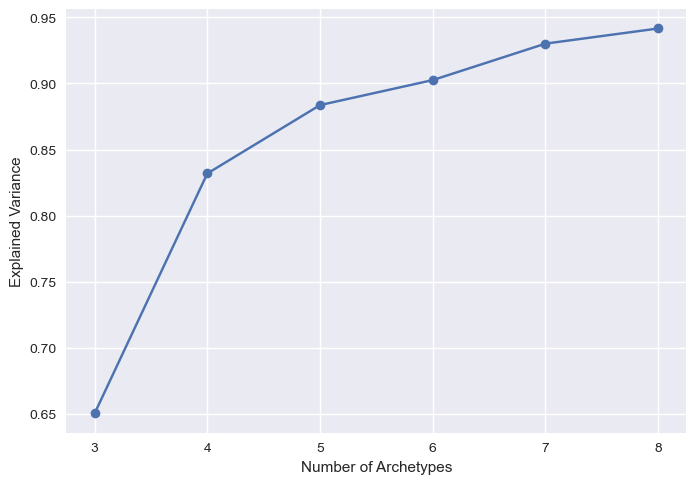

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


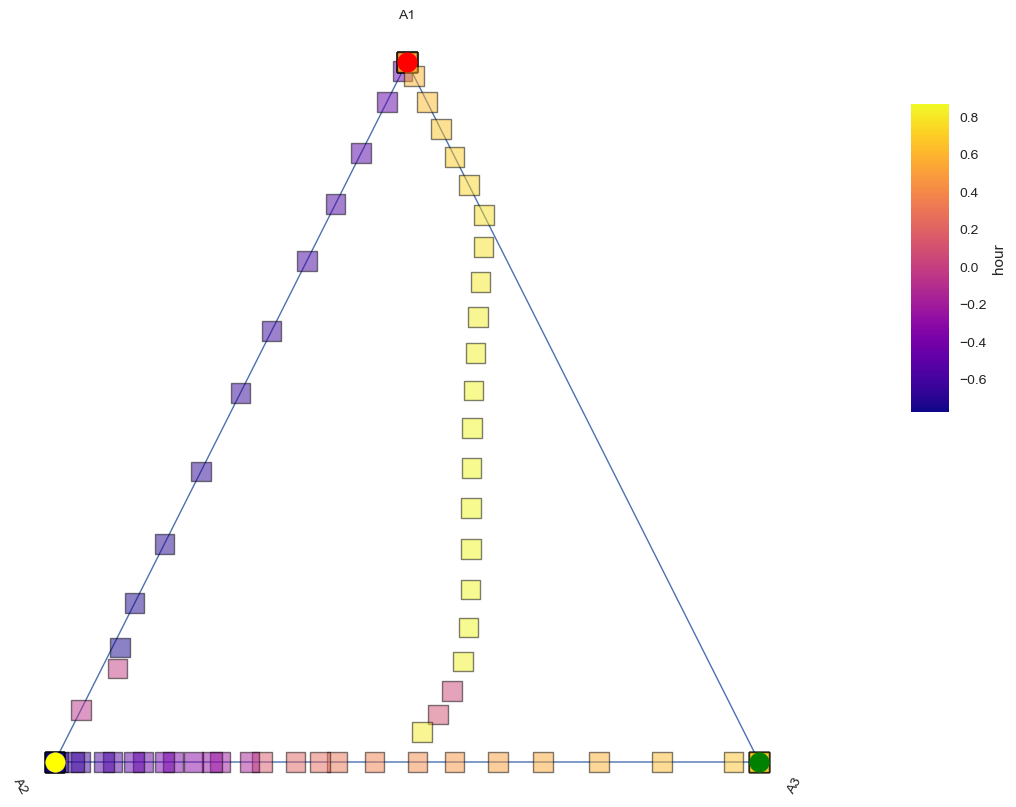

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



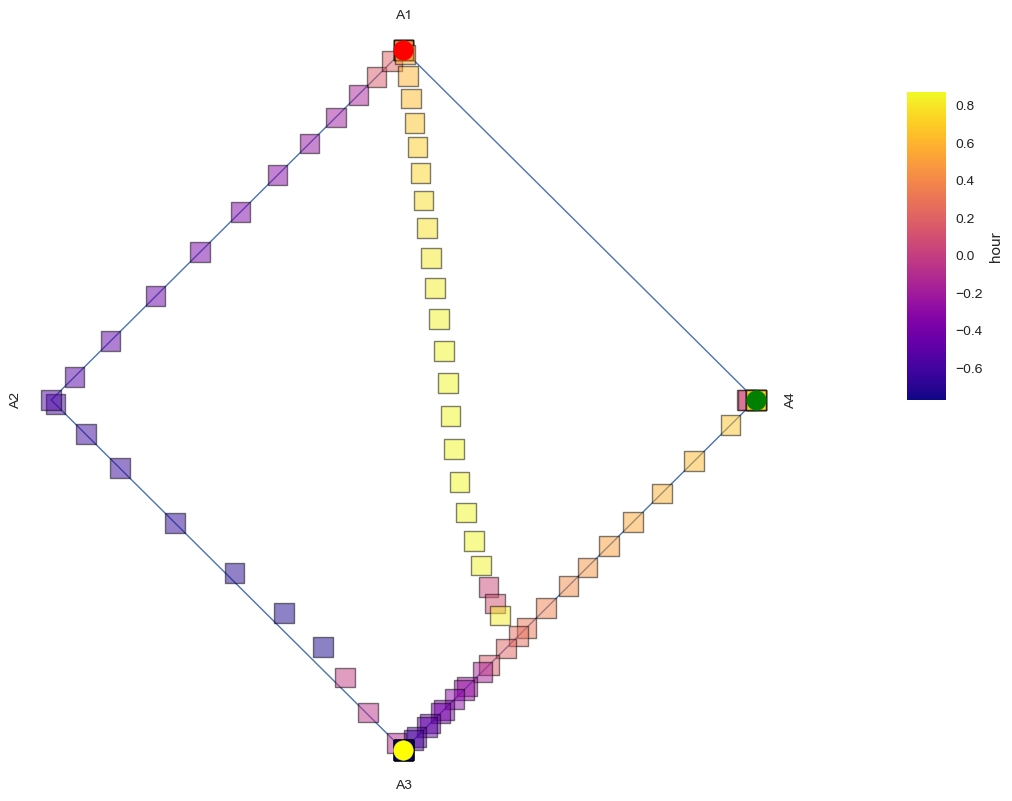

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


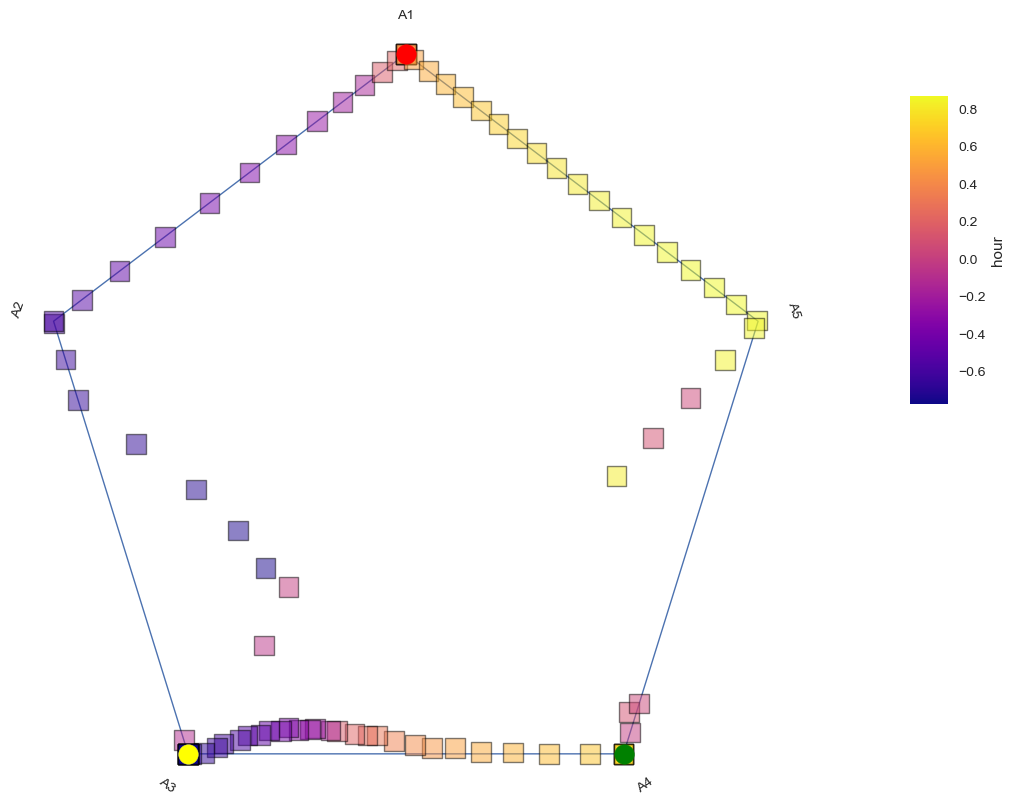

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



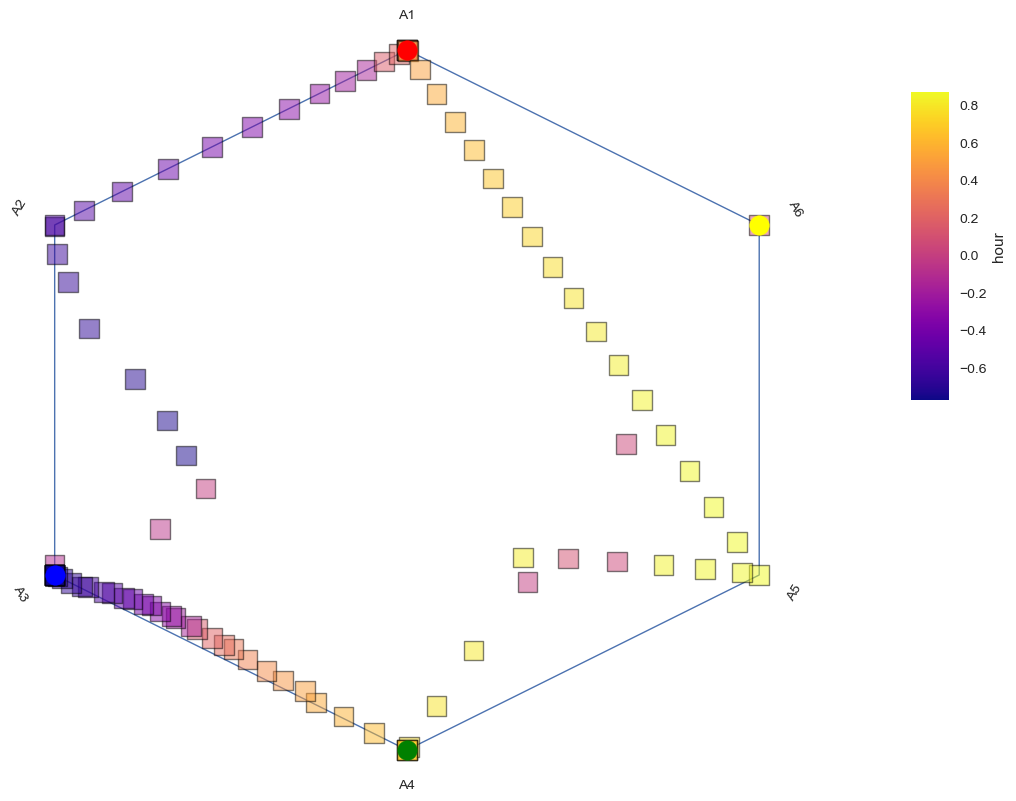

C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


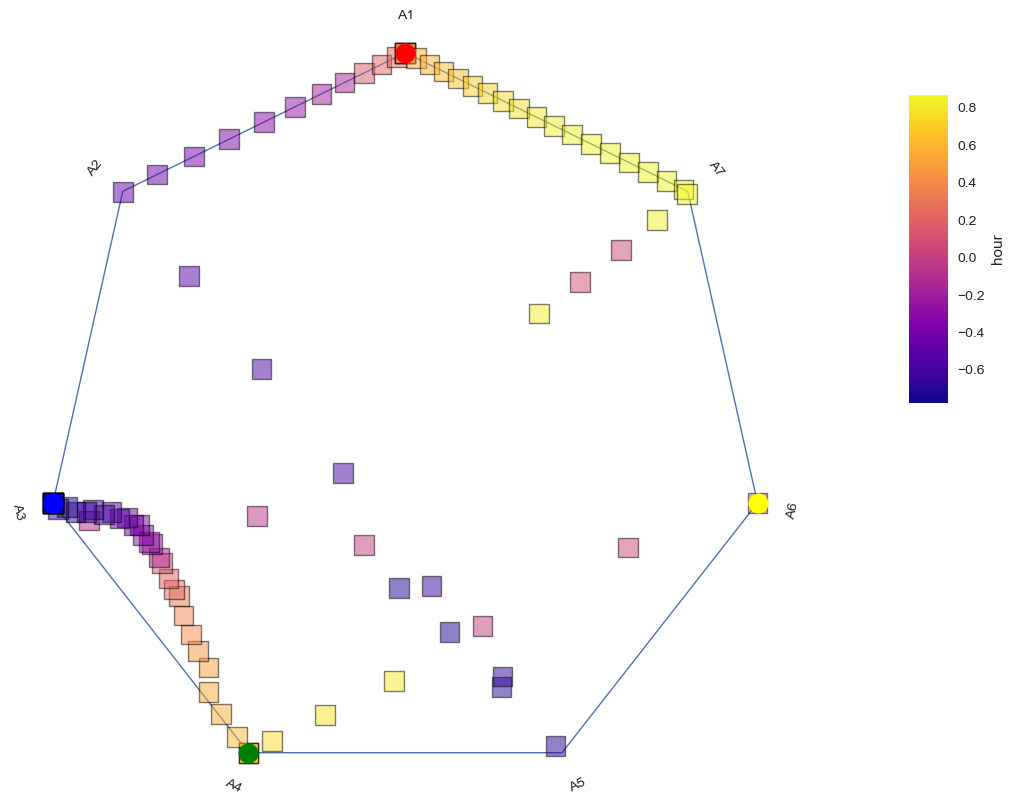

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



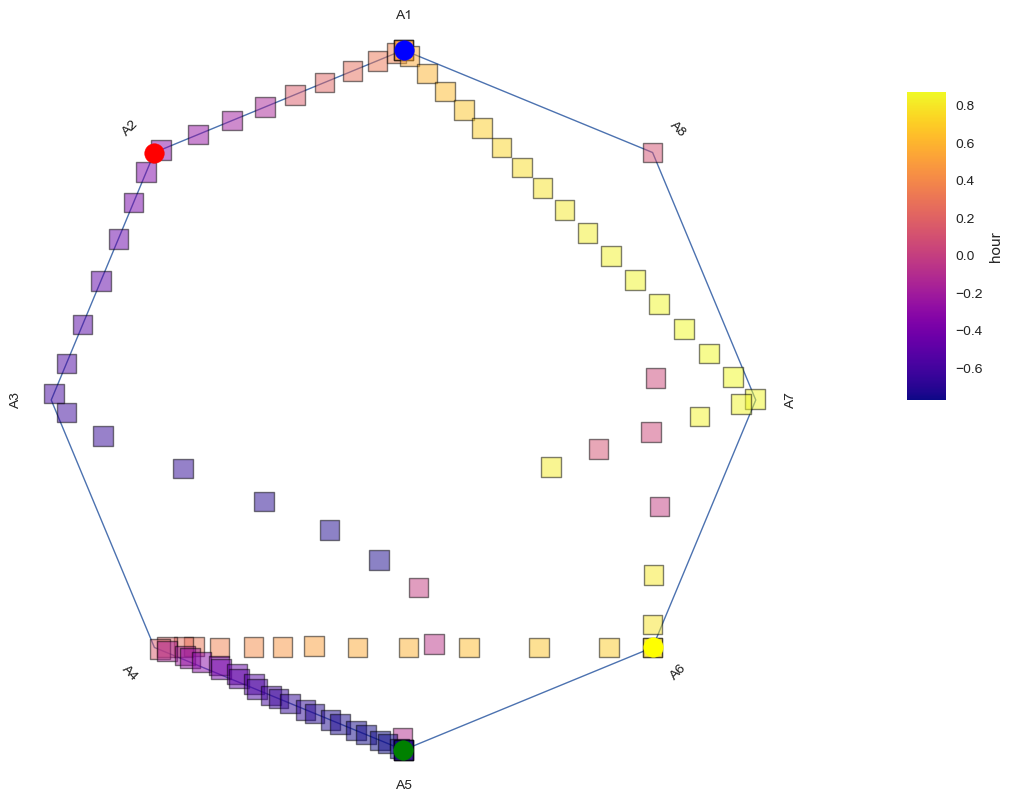

In [38]:
lst_feat = ['R' + str(i) for i in range(1,913+1)]

sc = StandardScaler()
X = April_L1_Atlantic_rates_df[lst_feat].values #Using level1_df here
X_scaled = sc.fit_transform(X)

AA_list_Atlantic_l1_april=[]
lst_exp_var_Atlantic_l1_april = []
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA_list_Atlantic_l1_april.append(AA)
    lst_exp_var_Atlantic_l1_april.append(AA.explained_variance_)
    
#explained variance
n_archs = list(range(3, 9))
plt.style.use('seaborn')
plt.plot(n_archs, lst_exp_var_Atlantic_l1_april, '-o')
plt.xlabel('Number of Archetypes')
plt.ylabel('Explained Variance')
plt.show()


#coloring - cosine zenith
legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations

# legend_color = list(April_L1_Atlantic_rates_df['timestamp'].dt.hour)
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border

#simplex plots    
flag = True
arr1 = AA_list_Atlantic_l1_april[0].archetypes.T
color_indices = []
for AA in AA_list_Atlantic_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'hour')

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



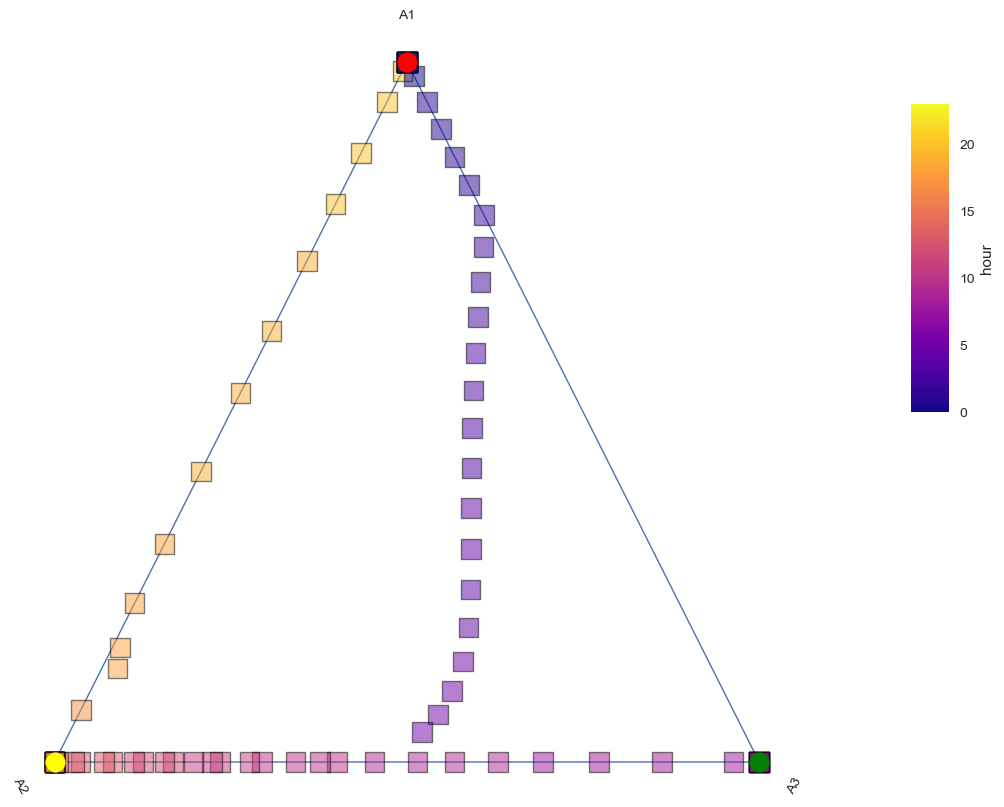

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



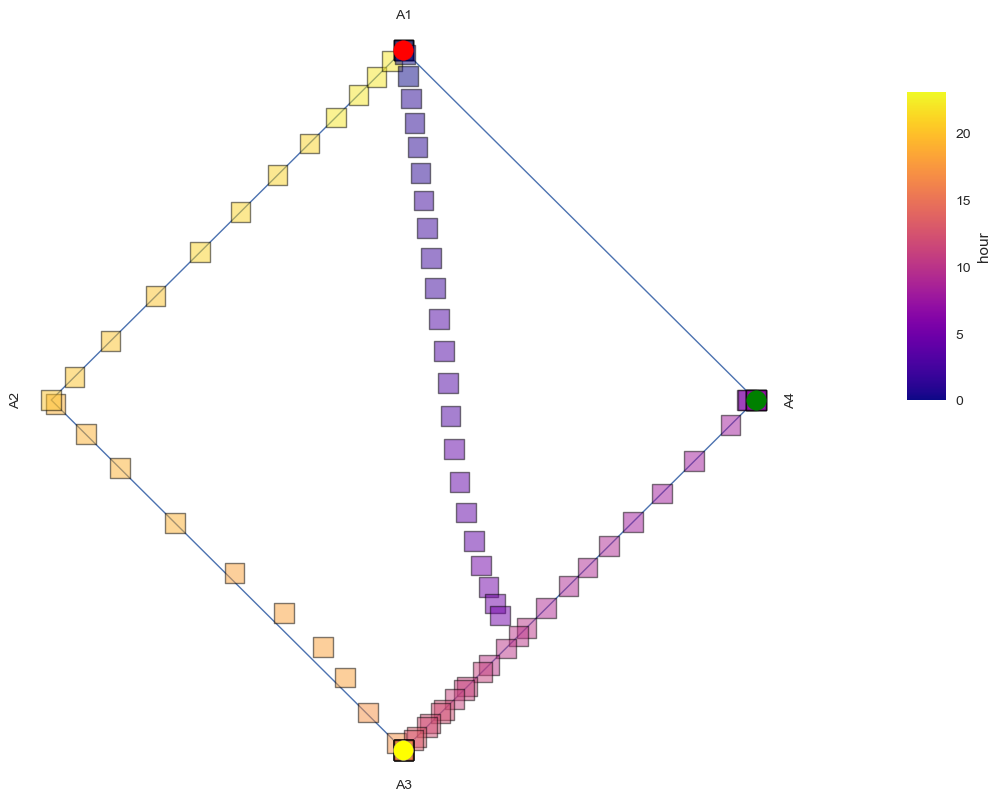

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



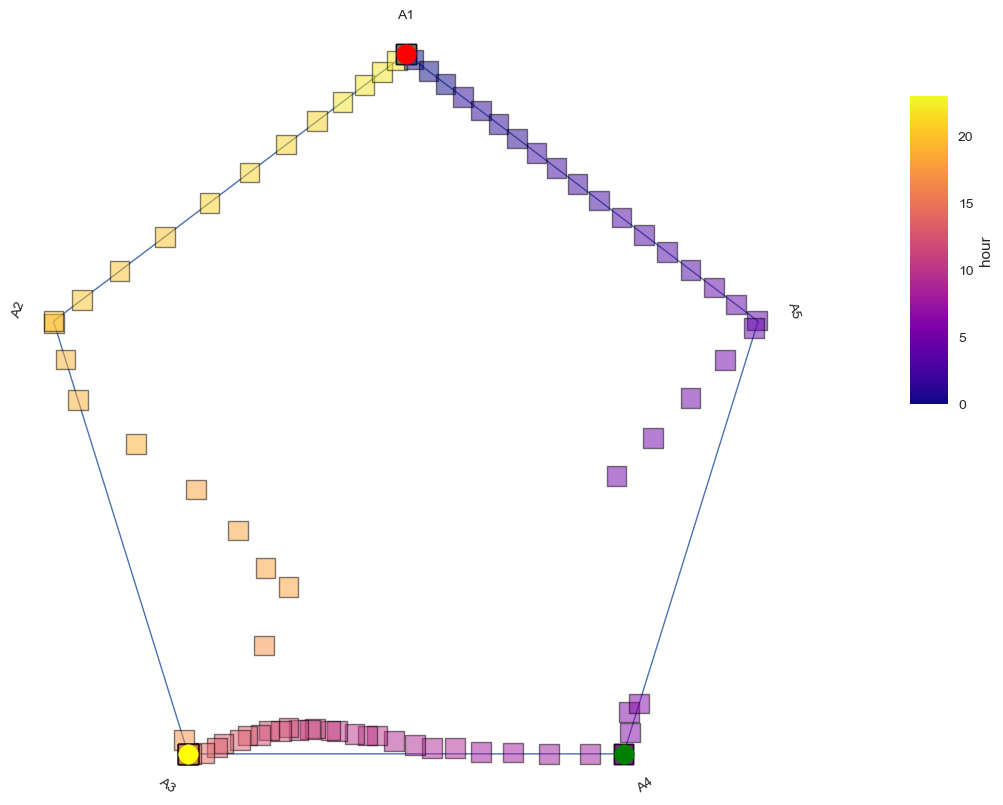

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



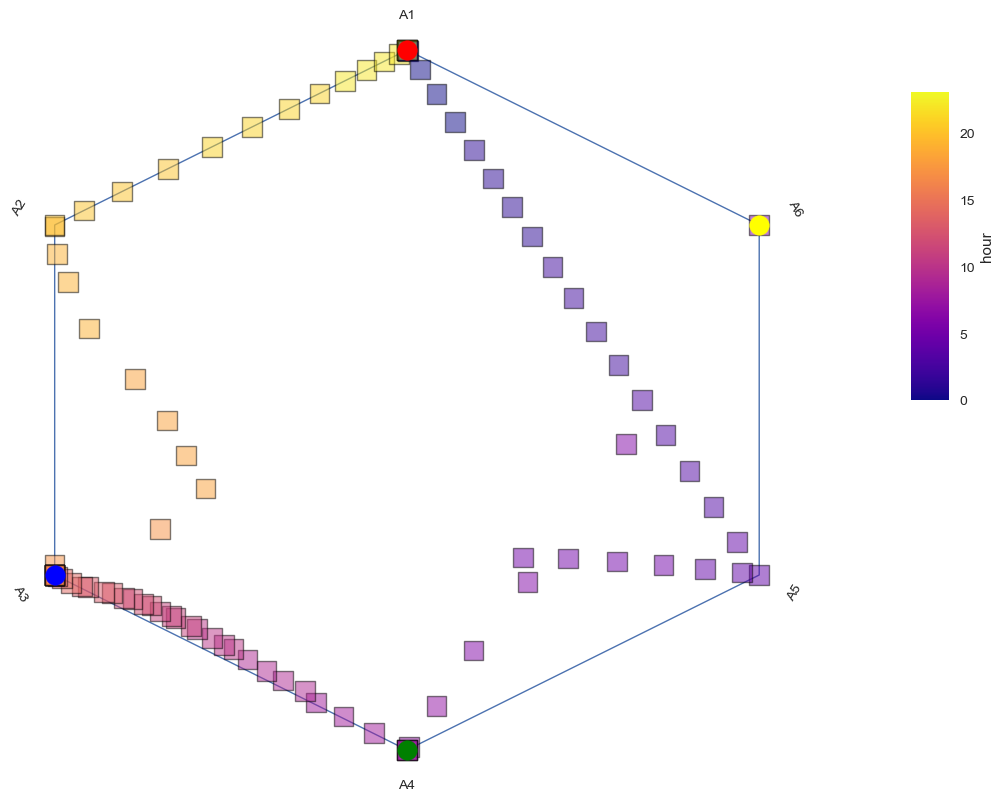

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



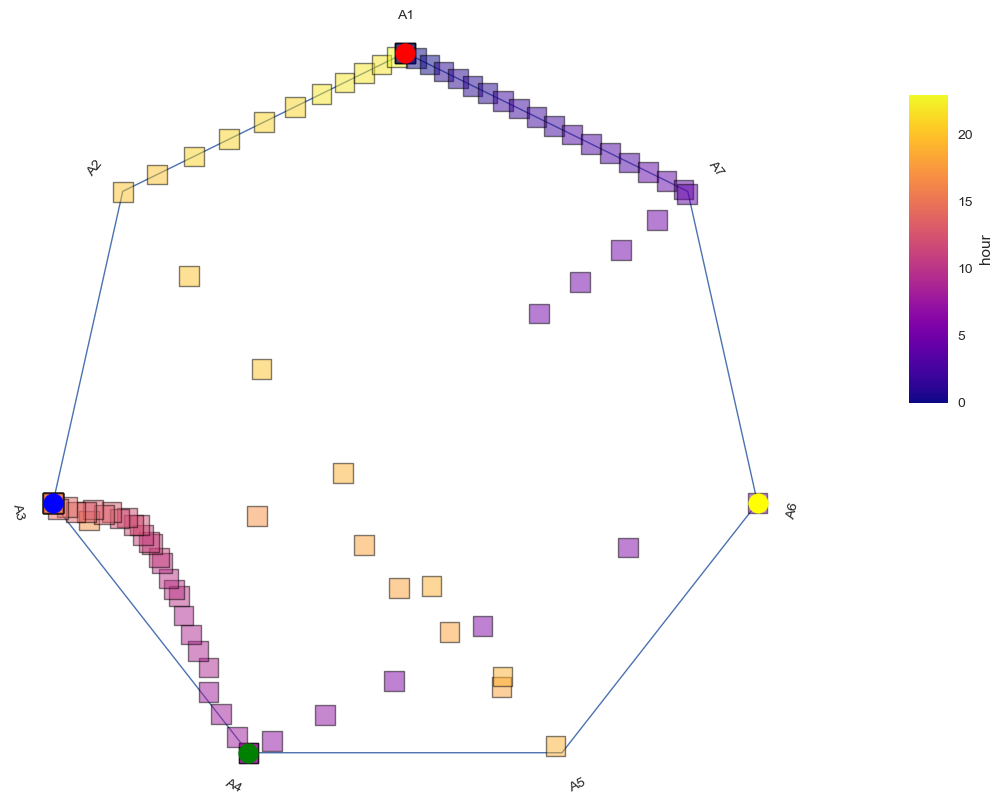

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_69764\1460208308.py:102: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



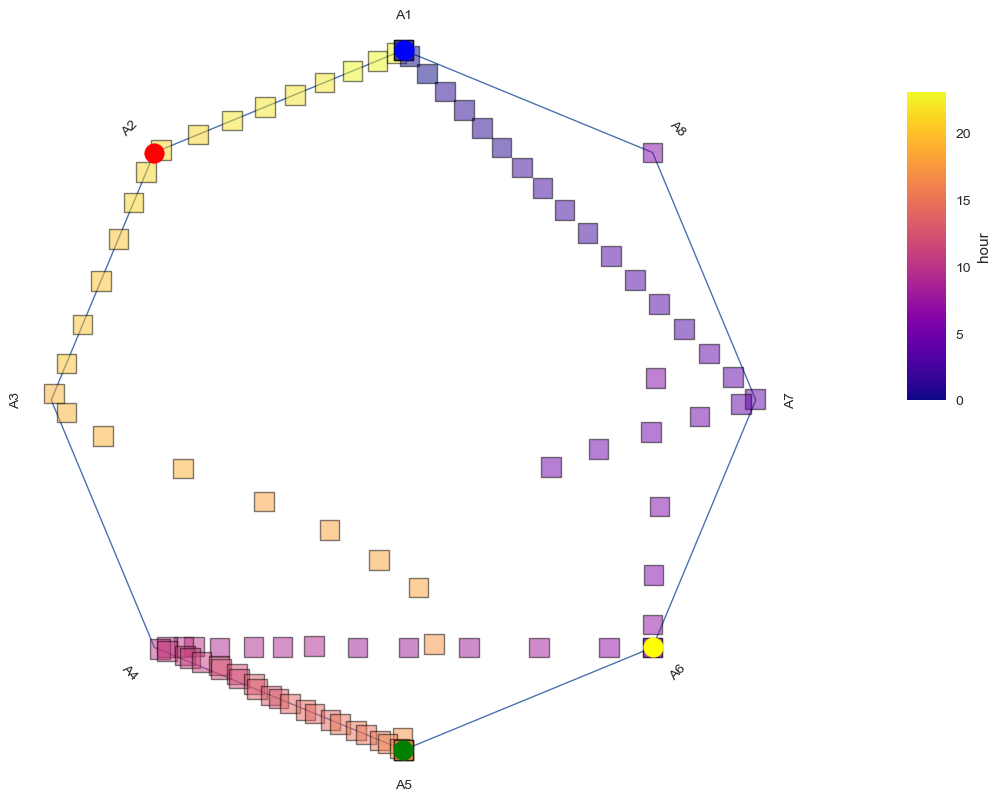

In [51]:
#coloring - cosine zenith
# legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
legend_color = list(April_L1_Atlantic_rates_df['timestamp'].dt.hour)
legend_color = [(i+9)%24 for i in legend_color]
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border

#simplex plots    
flag = True
arr1 = AA_list_Atlantic_l1_april[0].archetypes.T
color_indices = []
for AA in AA_list_Atlantic_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'hour')

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Given array
# arr = AA.alfa  # Your array here
arr = [[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]

# Create 3D plot
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=arr[0], y=arr[1], z=arr[2], mode='markers', marker=dict(size=5))])

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

# Meeting

In [49]:
for i in range(len(April_L1_LA_rates_df['cos_sza'])):
    print(April_L1_LA_rates_df['cos_sza'][i], April_L1_Atlantic_rates_df['timestamp'].dt.hour[i], April_L1_Atlantic_rates_df['timestamp'][i])

0.09819 21 2018-04-01 21:00:00
0.04444 21 2018-04-01 21:15:00
-0.009294 21 2018-04-01 21:30:00
-0.06279 8 2018-04-02 08:00:00
-0.1158 8 2018-04-02 08:15:00
-0.112 8 2018-04-02 08:30:00
-0.05889 8 2018-04-02 08:45:00
-0.005362 9 2018-04-02 09:00:00
0.04838 20 2018-04-02 20:15:00
0.1021 20 2018-04-02 20:30:00
0.8205 20 2018-04-02 20:45:00
0.8014 21 2018-04-01 21:45:00
0.7791 22 2018-04-01 22:00:00
0.7536 22 2018-04-01 22:15:00
0.7251 22 2018-04-01 22:30:00
0.6936 22 2018-04-01 22:45:00
0.6594 23 2018-04-01 23:00:00
0.6225 23 2018-04-01 23:15:00
0.5832 23 2018-04-01 23:30:00
0.5415 23 2018-04-01 23:45:00
0.4977 0 2018-04-02 00:00:00
0.452 0 2018-04-02 00:15:00
0.4081 0 2018-04-02 00:30:00
0.359 0 2018-04-02 00:45:00
0.3087 1 2018-04-02 01:00:00
0.2572 1 2018-04-02 01:15:00
0.2048 1 2018-04-02 01:30:00
0.1517 1 2018-04-02 01:45:00
-0.1682 2 2018-04-02 02:00:00
-0.2196 2 2018-04-02 02:15:00
-0.2699 2 2018-04-02 02:30:00
-0.3188 2 2018-04-02 02:45:00
-0.3661 3 2018-04-02 03:00:00
-0.4117 3 2